**Name:** Tan Wan Xuen <br>
**Student ID:** 2207214  <br>
**Project Title:** Machine Learning-Driven Predictive Loan Repayment behaviour <br>
**Notebook:**  Data Preprocessing<br>
**Overview:** Detailed feature analysis is performed by identifying the distribution of numerical features and relationship between categorical features and target variable. Data preprocessing is also conducted after having a better understanding on the dataset. Then, data spiltting is performed to split the dataset into train, test and validation sets. 
<br><br>
1.0 Read dataset<br>
2.0 Detailed Feature Analysis<br>
3.0 Data Visualisation<br>
4.0 Handle missing values<br>
5.0 Handle outliers<br>
6.0 One-hot Encoding <br>
7.0 Scaling <br>
8.0 Information about dataset after preprocessed <br>
9.0 Data Splitting <br>
10.0 Feature selection summary<br>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import pickle
from sklearn.model_selection import train_test_split
import os

## 1.0 Read dataset


In [4]:
DATASET_DIR = "../datasets"
df = pd.read_parquet(os.path.join(DATASET_DIR, "Single-Family-Loan-Level.parquet"))

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12983784 entries, 0 to 12983783
Data columns (total 31 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   loan_sequence_num                 string 
 1   monthly_reporting_period          float64
 2   cur_actual_UPB                    float64
 3   remaining_mths_to_legal_maturity  float64
 4   cur_int_rate                      float64
 5   cur_deferred_UPB                  float64
 6   ELTV                              float64
 7   credit_score                      float64
 8   first_payment_date                float64
 9   first_time_homebuyer              string 
 10  MI(%)                             float64
 11  num_of_units                      float64
 12  occupancy_status                  string 
 13  ori_DTI                           float64
 14  channel                           string 
 15  PPM_flag                          string 
 16  amorisation_type                  

---
## 2.0 Detailed Feature Anaylsis
In this section, categorical features are examined. Then, the distribution of the numerical variables are visualised. Based on results, decide on creating new features. Newly derived features may help improve model predictions. Repeat the processes and decide whether to create additional features or if the derived features are sufficient to proceed to model training. <br><br>
| **No.**           | **Categorical Variables**           | **Numerical Variables**                                                                                                 | 
|--------------|-----------------------|-----------------------------------------------------------------------------------------------------------------|
| 1 |    loan_sequence_num      | monthly_reporting_period |  
| 2| first_time_homebuyer      | cur_actual_UPB |  
| 3| occupancy_status       | installment |  
| 4|  channel     | remaining_mths_to_legal_maturity|  
| 5|  PPM_flag     | cur_int_rate |  
| 6|  amorisation_type       | cur_deferred_UPB|  
| 7|  property_state      |ELTV|  
| 8| property_type     | credit_score |  
| 9| loan_purpose     | first_payment_date  | 
| 10| seller_name      | MI(%)  |  
| 11| program_indicator     | ori_DTI | 
| 12| application_type      | loan_age  |  
| 13|   I/O_indicator    |  num_borrowers |
| 14|    MICI    |   | 
| 15|   postal_code  |  | 
| 16|  MSA  |  | 
| 17|  property_valuation_method  |  |

<br>

The newly generated feature is `region`. The stated summary statistics helps to identify categorical features with high cardinality and assists in deciding whether to drop them. 

In [6]:
# To calculate the coverage percentage of unique values
def calculate_unique_value_coverage(df_sample, column: str):
    value_counts = df_sample[column].value_counts(dropna=False)
    total_rows = df_sample[column].shape[0]
    coverage_percentage = (value_counts / total_rows) * 100
    coverage_percentage = coverage_percentage.round(4)  # Round for better readability
    return value_counts, coverage_percentage

# To display value counts along with the coverage percentage
def get_value_counts(df_sample, column: str):
    value_counts, coverage_percentage = calculate_unique_value_coverage(df_sample, column)
    
    result = pd.DataFrame({
        'Value': value_counts.index,  
        'Count': value_counts.values,  
        'Distribution (%)': coverage_percentage.values  
    })
    result = result.sort_values(by='Distribution (%)', ascending=False)

    print(f"\nColumn Name: {column}")
    print(result.to_string(index=True)) 


In [7]:
columns_to_print =  ['first_time_homebuyer', 'occupancy_status'
                , 'channel', 'PPM_flag', 'amorisation_type', 'property_state', 'property_type',
                'loan_purpose', 'seller_name', 'program_indicator', 'I/O_indicator', 'MICI','quarter', 'property_valuation_method']
for col in columns_to_print:
    get_value_counts(df, col)


Column Name: first_time_homebuyer
  Value    Count  Distribution (%)
0     N  7772952           59.8666
1     Y  5210832           40.1334

Column Name: occupancy_status
  Value     Count  Distribution (%)
0     P  11765885           90.6198
1     I    945380            7.2812
2     S    272519            2.0989

Column Name: channel
  Value    Count  Distribution (%)
0     R  6063458           46.7002
1     C  4808317           37.0332
2     B  2111995           16.2664
3     9       14            0.0001



Column Name: PPM_flag
  Value     Count  Distribution (%)
0     N  12983784             100.0

Column Name: amorisation_type
  Value     Count  Distribution (%)
0   FRM  12983784             100.0

Column Name: property_state
   Value    Count  Distribution (%)
0     TX  1290513            9.9394
1     FL  1161467            8.9455
2     CA   894395            6.8886
3     IL   589647            4.5414
4     OH   588632            4.5336
5     MI   499843            3.8497
6     PA   498700            3.8409
7     GA   474416            3.6539
8     NY   457608            3.5245
9     NC   445348              3.43
10    AZ   361463             2.784
11    IN   358617             2.762
12    NJ   352702            2.7165
13    VA   344062            2.6499
14    TN   308181            2.3736
15    CO   306187            2.3582
16    WA   292559            2.2533
17    MO   288939            2.2254
18    SC   260503            2.0064
19    MN   259665            1.9999
20    MD   248531

#### Summary statistics

In [8]:
df['postal_code'] = df['postal_code'].astype(int).astype(str)
cat_columns =  ['loan_sequence_num', 'postal_code', 'first_time_homebuyer', 'occupancy_status'
                , 'channel', 'PPM_flag', 'amorisation_type', 'property_state', 'property_type',
                'loan_purpose', 'seller_name', 'program_indicator', 'I/O_indicator', 'MICI','MSA','property_valuation_method']
df[cat_columns] = df[cat_columns].astype(object)
df.describe(include=['O'])

,loan_sequence_num,first_time_homebuyer,occupancy_status,channel,PPM_flag,amorisation_type,property_state,property_type,postal_code,loan_purpose,seller_name,program_indicator,property_valuation_method,I/O_indicator,MICI,MSA,quarter
count,12983784,12983784,12983784,12983784,12983784,12983784,12983784,12983784,12983784,12983784,12983784,12983784,12983784.0,12983784,12983784,11637934.0,12983784
unique,931731,2,3,4,1,1,54,5,888,3,24,4,5.0,1,3,434.0,4
top,F23Q10034337,N,P,R,N,FRM,TX,SF,75000,P,Other sellers,9,2.0,N,7,16984.0,2
freq,20,7772952,11765885,6063458,12983784,12983784,1290513,7621413,167398,10960636,4308554,11465113,11417629.0,12983784,7821992,362048.0,4264479


**Decision:** <br>
Features to drop:<br>
- `loan_sequence_num`, `MSA` and `postal_code` have high cardinality. 
- `PPM_flag`, `amorisation_type` and `I/O_indicator` have only one unique value in their respective columns. 
- `program_indicator` has 88.3% of missing values (labelled as '9').
- `MICI` has 60.24% categorised as '7', which is not applicable. 
<br>

Feature engineering:<br>
- `region` can be obtained from `property_state` to group states into broader regions.
<br>Since `property_state` is used for feature engineering, it should be dropped too. 

#### Feature Engineering
`region`

In [9]:
# Mapping state to region
def get_region(region: str)->str:
    group = {
        'West': ['WA','OR','CA','MT','ID','WY','NV','UT','CO','AZ','NM','HI','AK'],
        'Midwest': ['ND','SD','MN','NE','KS','MN','IA','MO','WI','IL','MI','IN','OH'],
        'South': ['TX','OK','AR','LA','MS','AL','TN','KY','GA','FL','SC','NC','VA','WV','DC','MD','DE'],
        'Northeast': ['PA','NY','NJ','RI','CT','MA','VT','NH','ME']
    }
    for category, keywords in group.items():
        if any(keyword.lower() in region.lower() for keyword in keywords):
            return category
    return 'Other' 

df['region'] = df['property_state'].apply(get_region)
get_value_counts(df, 'region')


Column Name: region
       Value    Count  Distribution (%)
0      South  5436651           41.8726
1    Midwest  3131793           24.1208
2       West  2601736           20.0383
3  Northeast  1809831           13.9392
4      Other     3773            0.0291


Reason: `region` reduces complexity while retaining the geographic meaning. Also, regional grouping balances representation. The states are grouped into regions by referring to https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf. 

#### Numerical Features

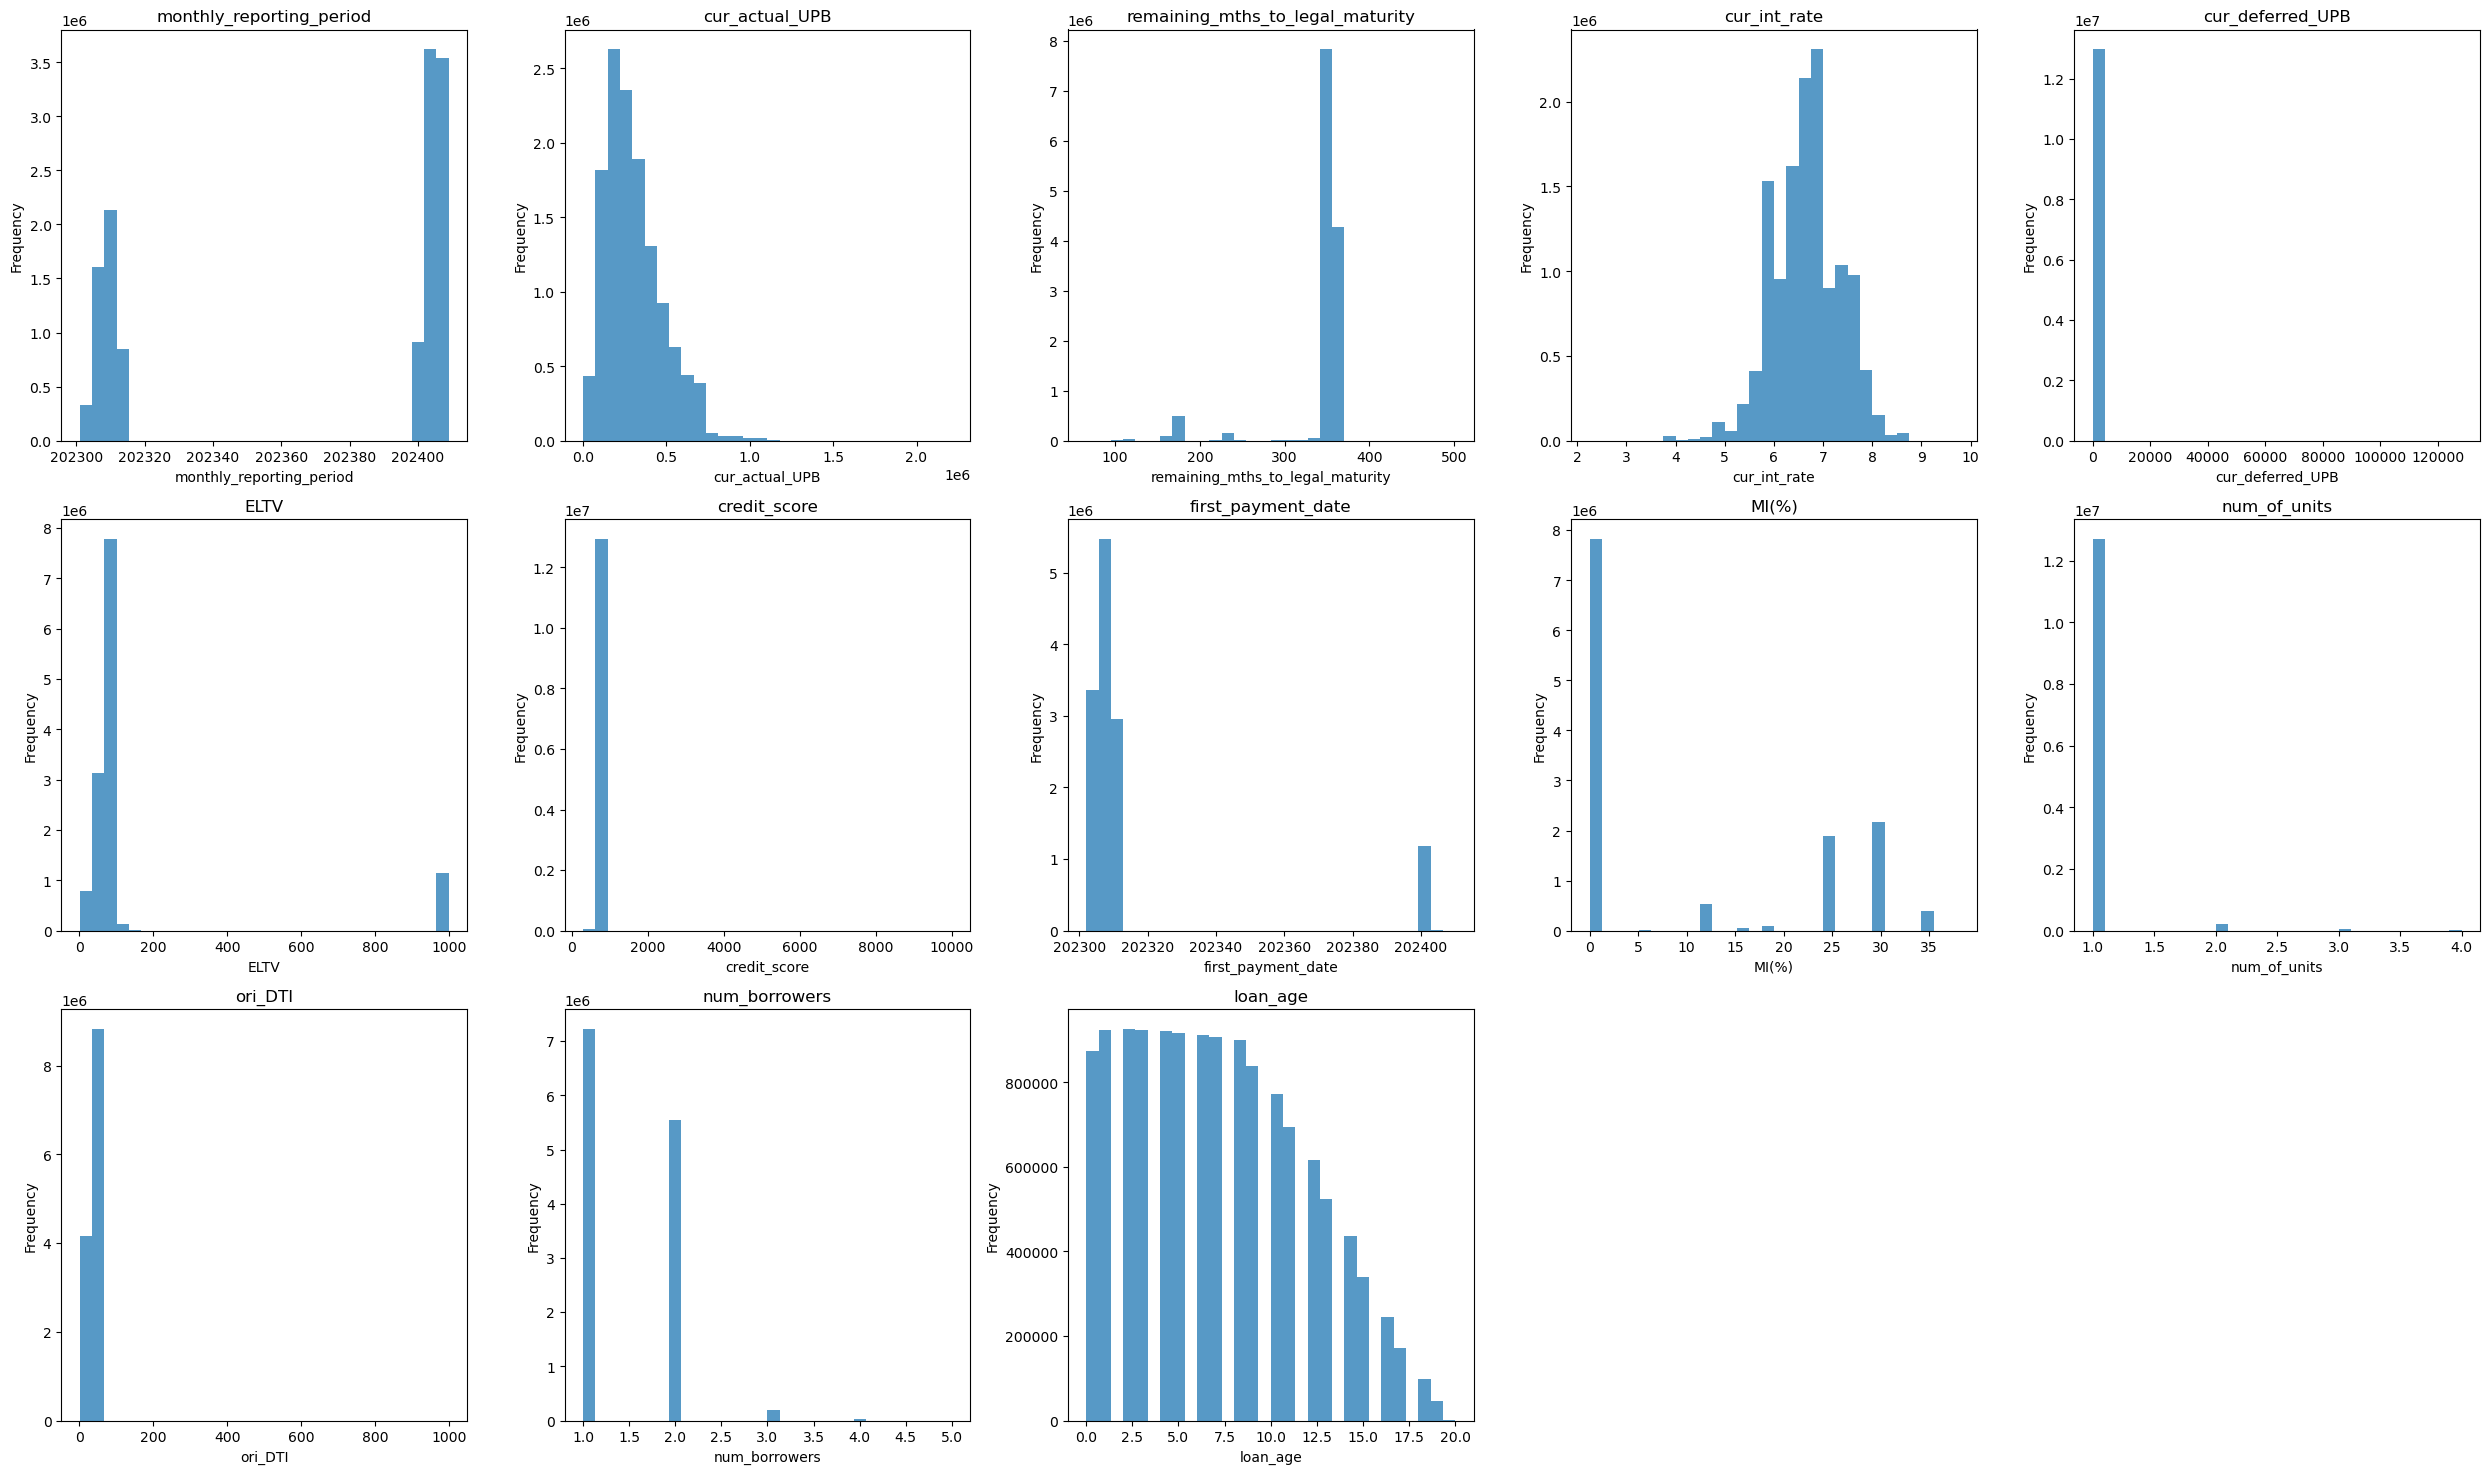

In [10]:
def plot_distribution(df_sample, column: str):
    num_cols = 5  
    num_rows = (len(column) + num_cols - 1) // num_cols  

    plt.figure(figsize=(25, 5 * num_rows)) 

    for i, col in enumerate(column):
        ax= plt.subplot(num_rows, num_cols, i + 1)  
        sns.histplot(df_sample[col], bins=30, ax=ax)
        plt.title(col)
        plt.xlabel(col)
        plt.ylabel("Frequency")
        
        for patch in ax.patches:
            patch.set_edgecolor("none")

    plt.tight_layout()  
    plt.show()

# Plot histogram distributions for each feature 
num_columns = df.select_dtypes(include=[np.number]).columns.tolist()
plot_distribution(df, num_columns)

In [11]:
df.describe()

,monthly_reporting_period,cur_actual_UPB,remaining_mths_to_legal_maturity,cur_int_rate,cur_deferred_UPB,ELTV,credit_score,first_payment_date,MI(%),num_of_units,ori_DTI,num_borrowers,loan_age
count,1.298378e+07,1.298378e+07,1.298378e+07,1.298378e+07,1.298378e+07,1.298378e+07,1.298378e+07,1.298378e+07,1.298378e+07,1.298378e+07,1.298378e+07,1.298378e+07,1.298378e+07
mean,2.023686e+05,3.037413e+05,3.424137e+02,6.644375e+00,5.347773e+00,1.541361e+02,7.519444e+02,2.023160e+05,1.042375e+01,1.029129e+00,3.811313e+01,1.462492e+00,6.980639e+00
std,4.666568e+01,1.724761e+05,4.191806e+01,6.778005e-01,3.908781e+02,2.646614e+02,1.644470e+02,2.726840e+01,1.339896e+01,2.185681e-01,1.128667e+01,5.391060e-01,4.662366e+00
min,2.023010e+05,0.000000e+00,6.600000e+01,2.250000e+00,0.000000e+00,1.000000e+00,3.000000e+02,2.023020e+05,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,2.023100e+05,1.756517e+05,3.490000e+02,6.125000e+00,0.000000e+00,6.300000e+01,7.200000e+02,2.023050e+05,0.000000e+00,1.000000e+00,3.200000e+01,1.000000e+00,3.000000e+00
50%,2.024020e+05,2.690000e+05,3.530000e+02,6.625000e+00,0.000000e+00,7.800000e+01,7.570000e+02,2.023080e+05,0.000000e+00,1.000000e+00,4.000000e+01,1.000000e+00,7.000000e+00
75%,2.024060e+05,3.980042e+05,3.570000e+02,7.000000e+00,0.000000e+00,9.000000e+01,7.850000e+02,2.023100e+05,2.500000e+01,1.000000e+00,4.600000e+01,2.000000e+00,1.000000e+01
max,2.024090e+05,2.212000e+06,5.010000e+02,9.750000e+00,1.282000e+05,9.990000e+02,9.999000e+03,2.024100e+05,3.800000e+01,4.000000e+00,9.990000e+02,5.000000e+00,2.000000e+01


**Decision:**<br>
Feature to drop:
- `first_payment_date`, `monthly_reporting_period` and `remaining_mths_to_legal_maturity` as past period will not occur again. 

---
## 3.0 Data visualisation

In [12]:
# Drop the unused columns before data visualisation and check the chosen features infomation
df = df.drop(columns=['loan_sequence_num', 'PPM_flag', 'amorisation_type', 'I/O_indicator', 'seller_name', 'first_payment_date', 'property_state', 'postal_code', 'monthly_reporting_period', 'remaining_mths_to_legal_maturity', 'MSA', 'MICI', 'program_indicator'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12983784 entries, 0 to 12983783
Data columns (total 19 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   cur_actual_UPB             float64
 1   cur_int_rate               float64
 2   cur_deferred_UPB           float64
 3   ELTV                       float64
 4   credit_score               float64
 5   first_time_homebuyer       object 
 6   MI(%)                      float64
 7   num_of_units               float64
 8   occupancy_status           object 
 9   ori_DTI                    float64
 10  channel                    object 
 11  property_type              object 
 12  loan_purpose               object 
 13  num_borrowers              float64
 14  property_valuation_method  object 
 15  loan_age                   float64
 16  quarter                    object 
 17  target                     bool   
 18  region                     object 
dtypes: bool(1), float64(10), object(8)
memor

In [13]:
# To plot pie chart
def plot_pie(ax, data, column, title, colors):
    count=data.groupby(column).size().reset_index(name='count_case')

    pie,_=ax.pie(count['count_case'], colors=colors)
    ax.set_title(title)
    ax.legend(pie,count[column],title=column,
              loc="upper left",fontsize='small',bbox_to_anchor=(1,0,0.5,1))
    
# To plot bar chart    
def plot_bar(ax, data, x, y, title, xlabel, ylabel, palette, hue=None):
    sns.barplot(data=data, x=x, y=y, palette=palette, ax=ax, hue=hue,ci=None)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_position(('data', 0))

# To plot box plot
def plot_box(ax, data, x, y, title, xlabel, ylabel, palette, hue=None):
    sns.boxplot(data=data, x=x, y=y, palette=palette, ax=ax, hue=hue, whiskerprops={'color': 'gray'},
                capprops={'color': 'gray'},
                flierprops={'marker': 'o', 'color': 'gray', 'markersize': 5})
    ax.set_title(title, fontsize=15)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_position(('data', 0))

# Define colors
colors_set1 = ['#cbe6b8', '#a4bf91', '#f5eace', '#929da1','#738599','#b8c1d6','#6b8078']
colors_set2 = ['#dbbfbf', '#bfc8db', '#7c7f8a', '#FAEEF5']
colors_set3 = ['#cabccc', '#a095a1', '#E8D4E1','#FCE9E9','#E8EAF6', '#FAEEF5']
colors_set4 = ['#F5B09C', '#FDECE8', '#FBCCB3', '#FCF4E0', '#F9E19E']

# Define labels mapping to respective features
label_mapping_occupancy = {
    'P': 'Primary Residence',
    'I': 'Investment Property',
    'S': 'Second Home',
    '9': 'Not Available'
}

label_mapping_hb = {
    'Y': 'First Time Homebuyer',
    'N': 'Not First Time Homebuyer'
}

label_mapping_property = {
    'CO': 'Condo',
    'PU': 'PUD',
    'MH': 'Manufactured Housing',
    'SF': 'Single-Family',
    'CP': 'Co-op',
    '99': 'Not Available'
}

label_mapping_purpose = {
    'P' : 'Purchase', 
    'C' : 'Refinance - Cash Out', 
    'N' : 'Refinance - No Cash Out' ,
    'R' : 'Refinance - Not Specified', 
    '9' : 'Not Available'
}


### 3.1 Loan Distribution and Borrower behaviour Overview
To understand loan purpose, loan size variations, lending patterns, and risk profiles by providing a comprehensive view of loan distribution and borrower behaviour

C:\Users\User\AppData\Local\Temp\ipykernel_4860\2295168557.py:23: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.boxplot(data=data, x=x, y=y, palette=palette, ax=ax, hue=hue, whiskerprops={'color': 'gray'},
C:\Users\User\AppData\Local\Temp\ipykernel_4860\2295168557.py:23: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.boxplot(data=data, x=x, y=y, palette=palette, ax=ax, hue=hue, whiskerprops={'color': 'gray'},
C:\Users\User\AppData\Local\Temp\ipykernel_4860\2295168557.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data, x=x, y=y, palette=palette, ax=ax, hue=hue,ci=None)
C:\Users\User\AppData\Local\Temp\ipykernel_4860\4085456553.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0,1].set_xticklabels([label_mapping_occupancy.

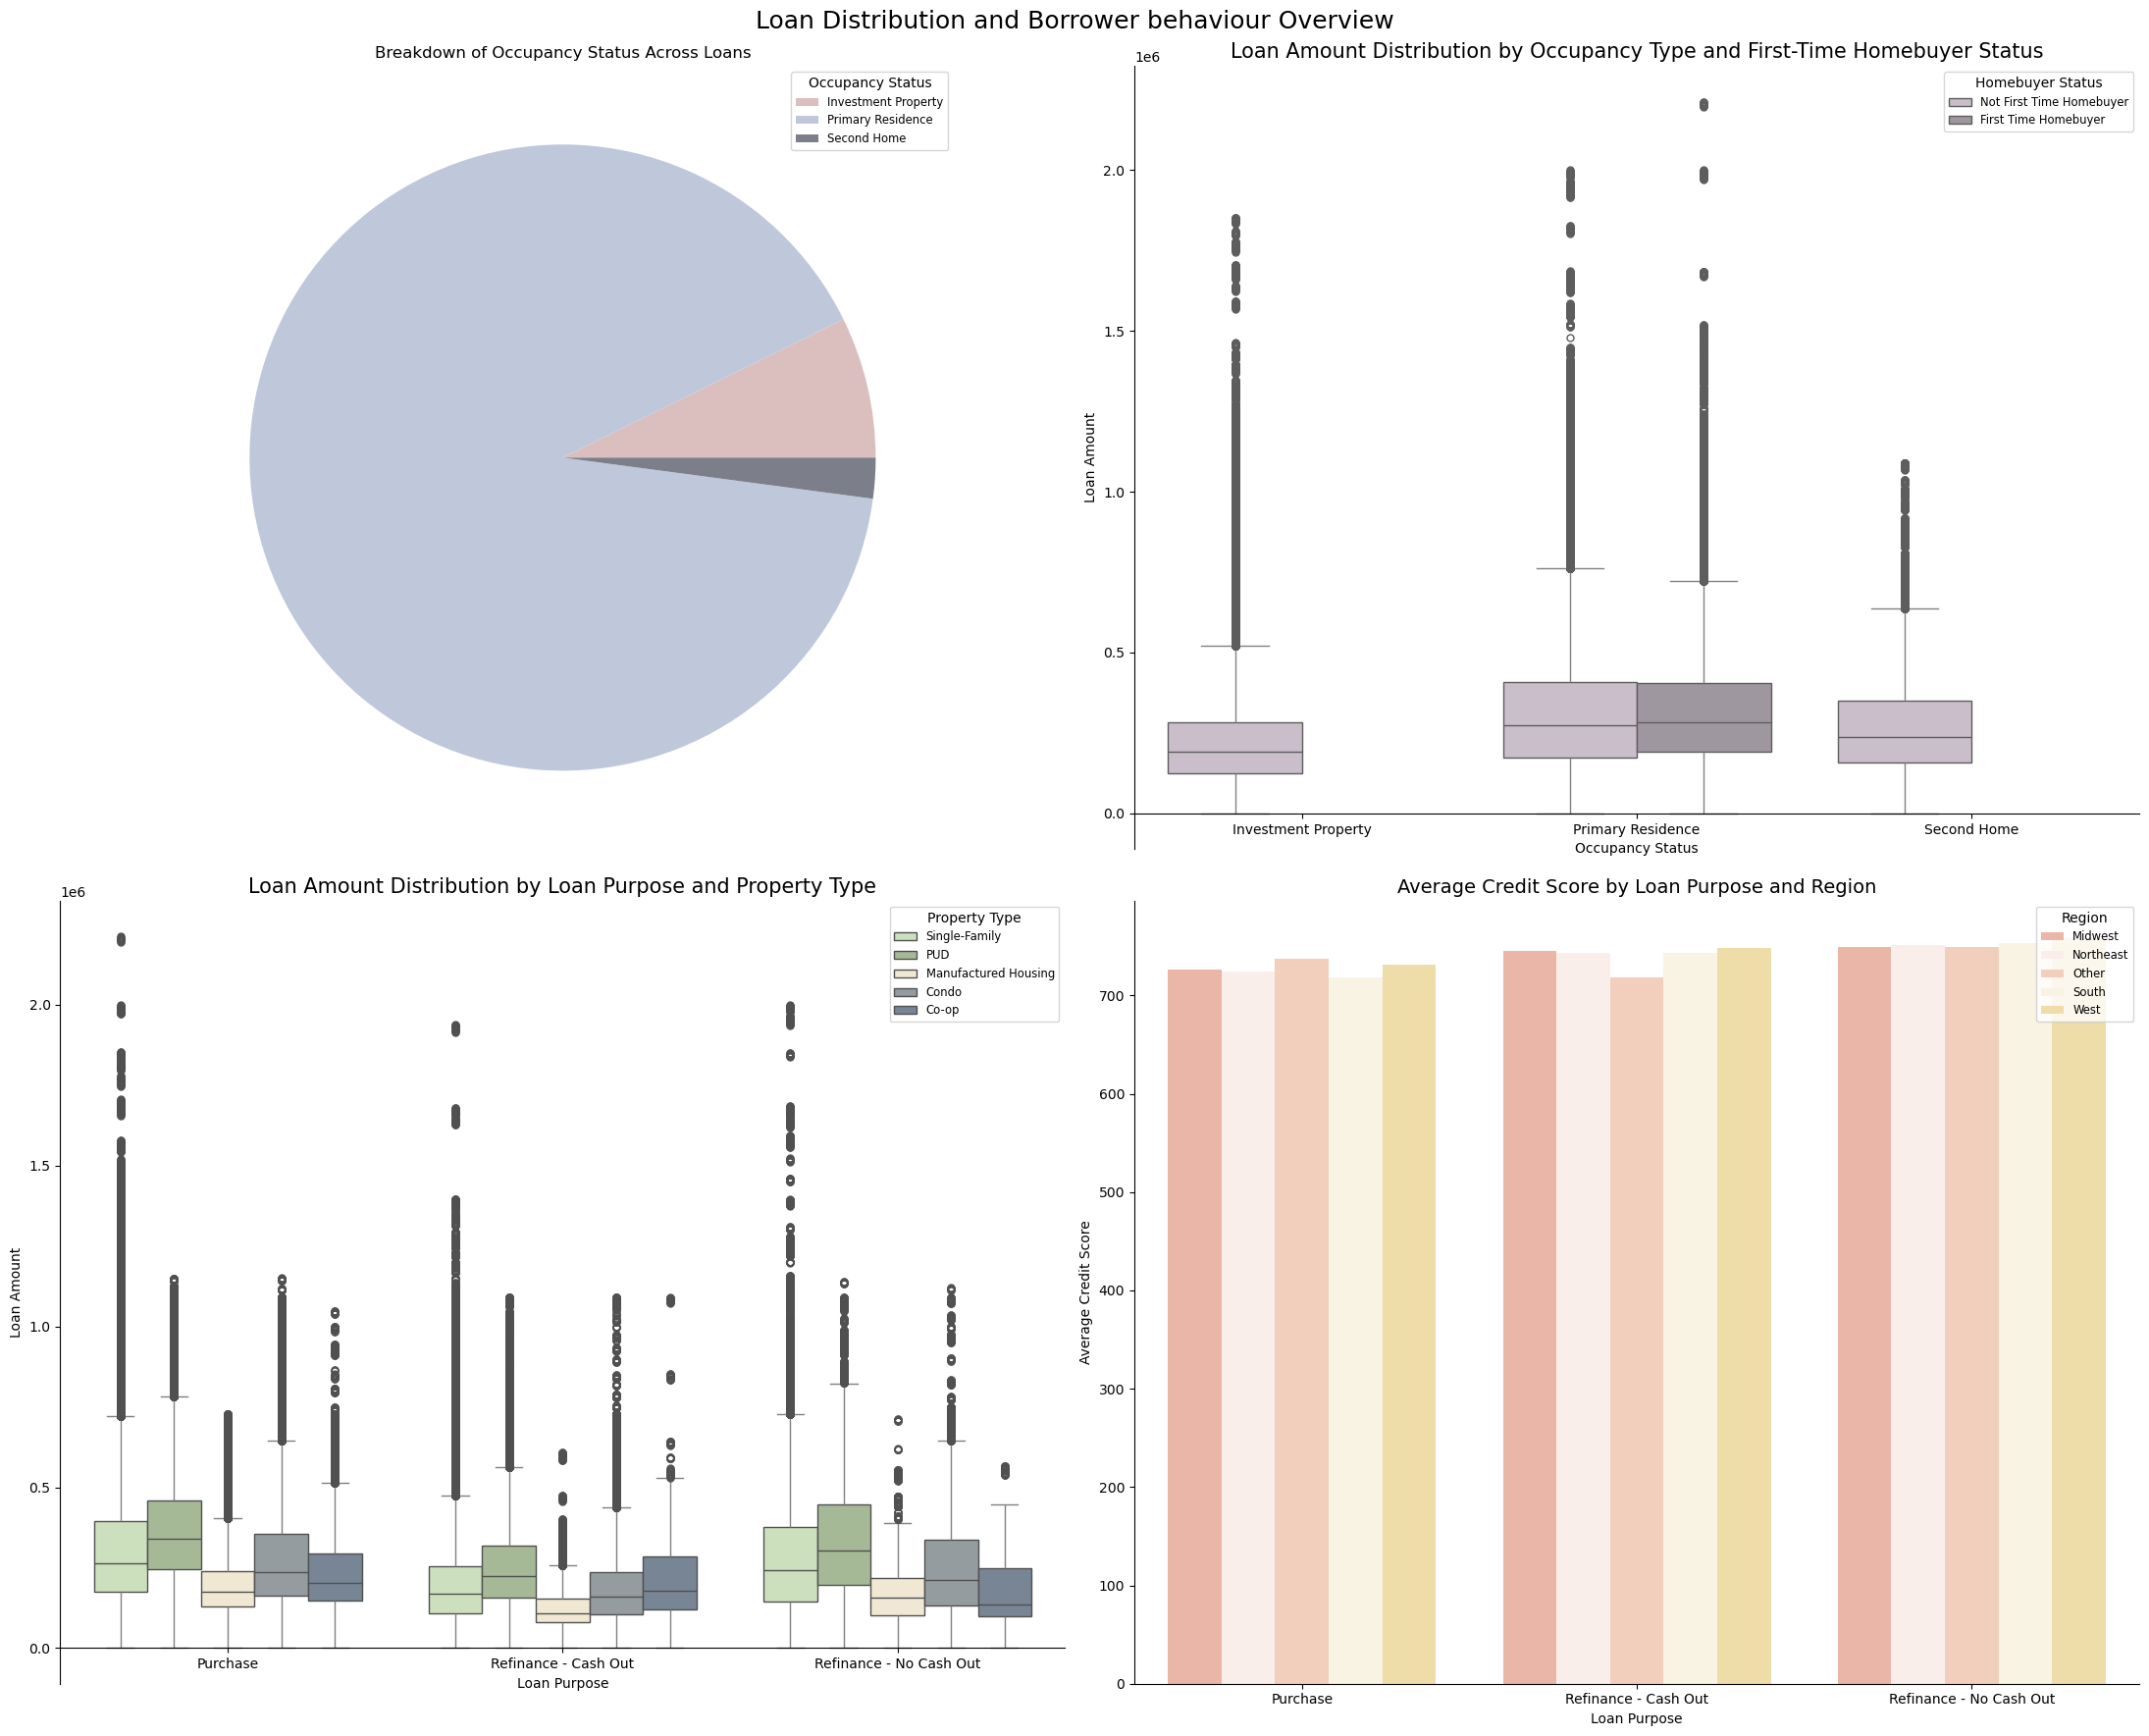

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(22, 18))
fig.suptitle("Loan Distribution and Borrower behaviour Overview", fontsize=18) 

# Graph 1: Breakdown of Occupancy Status Across Loans
plot_pie(ax[0,0], df, 'occupancy_status', 'Breakdown of Occupancy Status Across Loans', colors_set2)

# Graph 2: Loan Amount Distribution by Occupancy Type and First-Time Homebuyer Status
plot_box(ax[0,1], df, 'occupancy_status', 'cur_actual_UPB', 'Loan Amount Distribution by Occupancy Type and First-Time Homebuyer Status', 
         'Occupancy Status', 'Loan Amount', colors_set3, 'first_time_homebuyer')

# Graph 3: Loan Amount Distribution by Loan Purpose and Property Type
plot_box(ax[1,0], df, 'loan_purpose', 'cur_actual_UPB', 'Loan Amount Distribution by Loan Purpose and Property Type', 
         'Loan Purpose', 'Loan Amount', colors_set1, 'property_type')

# Graph 4: Average Credit Score by Loan Purpose and Region'
df_filter = df[(df['credit_score'] >= 300.0) & (df['credit_score'] <= 850.0)]  # Valid credit scores
df_avg_credit = df_filter.groupby(['loan_purpose', 'region'], as_index=False).agg({'credit_score': 'mean'})
plot_bar(ax[1,1], df_avg_credit, 'loan_purpose', 'credit_score', 'Average Credit Score by Loan Purpose and Region', 
         'Loan Purpose', 'Average Credit Score', colors_set4,'region')


# Give precise label names to each legend
handles_hb, labels_hb = ax[0,1].get_legend_handles_labels()
handles_property, labels_property = ax[1,0].get_legend_handles_labels()

# Map labels
occupancy_labels = [label_mapping_occupancy.get(x, x) for x in df['occupancy_status'].unique()]
new_labels_hb = [label_mapping_hb.get(label, label) for label in labels_hb]
new_labels_property = [label_mapping_property.get(label, label) for label in labels_property]

# Assign legends
ax[0,0].legend(occupancy_labels, title='Occupancy Status', loc="upper right", fontsize='small')
ax[0,1].legend(handles_hb, new_labels_hb, title='Homebuyer Status', loc="upper right", fontsize='small')
ax[1,0].legend(handles_property, new_labels_property, title='Property Type', loc="upper right", fontsize='small')
ax[1,1].legend(title='Region', loc="upper right", fontsize='small')

# Set x-axis labels
ax[0,1].set_xticklabels([label_mapping_occupancy.get(x, x) for x in df['occupancy_status'].unique()])
ax[1,0].set_xticklabels([label_mapping_occupancy.get(x, x) for x in df['occupancy_status'].unique()]) 
ax[1,0].set_xticklabels([label_mapping_purpose.get(x, x) for x in df['loan_purpose'].unique()]) 
ax[1,1].set_xticklabels([label_mapping_purpose.get(x, x) for x in df['loan_purpose'].unique()])  

plt.tight_layout()
plt.show()


**Key Insights:**
<br>There are many outliers but they have been taken into consideration as valuable examples in the analysis.
- It reflects that the majority lending activity is on the **primary residences**, whereas the investment loans formed a much smaller market. The **first-time homebuyer** may face affordability challenges or limits on borrowing, hence showing they are having less amount of debts. Also, the type of property matters greatly when it comes to how much loan amount is borrowed, with a **single-family home** giving the largest portion of loan amount.  The average credit score of the borrowers is relatively high across all loan purposes and regions. This indicates that the borrowers have **strong creditworthiness**. 

<br>Differences in lending behaviour are driven by affordability and risk assessment indicated by the interplay of loan purpose, property type and borrower category. 

### 3.2 Distribution of Current Loan Amount by Repayment Status and Region

C:\Users\User\AppData\Local\Temp\ipykernel_4860\2346645365.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label_mapping_target.get(x, x) for x in df['target'].unique()])


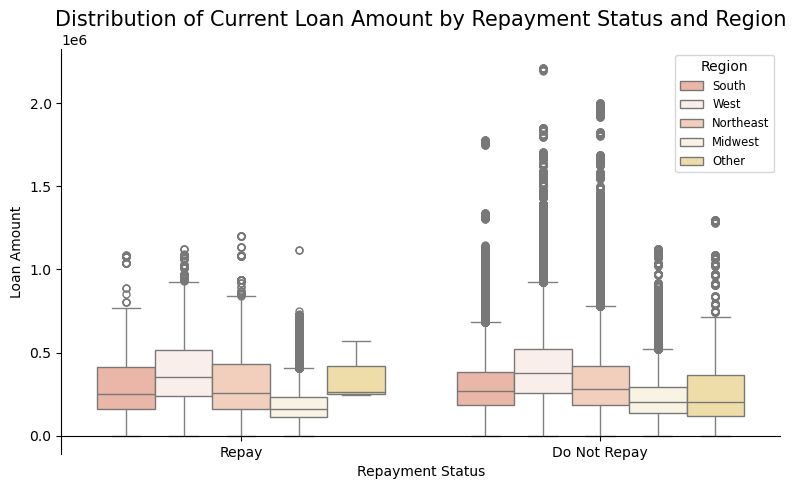

In [15]:
fig,ax=plt.subplots(1,1,figsize=(8,5))

# Graph: Distribution of Current Loan Amount by Repayment Status and Region
plot_box(ax, df, 'target', 'cur_actual_UPB','Distribution of Current Loan Amount by Repayment Status and Region', 'Repayment Status','Loan Amount', colors_set4, 'region')

label_mapping_target = {True : 'Repay', False : 'Do Not Repay'}
ax.set_xticklabels([label_mapping_target.get(x, x) for x in df['target'].unique()])
ax.legend(title='Region', loc="upper right", fontsize='small')

plt.tight_layout()
plt.show()

**Key Insights:** <br>
The boxplot visualises the distribution of current loan amounts based on repayment status across different regions. There are many outliers but they have been taken into consideration as valuable examples in the analysis. Most debtors who exhibit a "Do Not Repay" repayment behaviour tend to have higher loan amounts. The overall distribution across different regions is similar across repayment statuses. However, the Midwest region tends to have lower median loan amounts, possibly indicating differences in lending patterns or borrower profiles. Lenders and policymakers should strengthen risk management strategies to better support high-loan borrowers and reduce default rates.

---
## 4.0 Handle missing values

In [16]:
df.isnull().sum()

cur_actual_UPB               0
cur_int_rate                 0
cur_deferred_UPB             0
ELTV                         0
credit_score                 0
first_time_homebuyer         0
MI(%)                        0
num_of_units                 0
occupancy_status             0
ori_DTI                      0
channel                      0
property_type                0
loan_purpose                 0
num_borrowers                0
property_valuation_method    0
loan_age                     0
quarter                      0
target                       0
region                       0
dtype: int64

**Decision:**<br>
Upon examination, it was found that some features contain missing values marked as '9', '999.0' or '9999.0'. The distribution of missing values is as follows:<br>
- `ELTV` 8.89% 
- `credit_score` 0.00029% 
- `ori_DTI` 0.000045%<br>

To handle these missing values, mean imputation was applied to `ELTV`, while missing values in `credit_score` and `ori_DTI` were removed.

In [17]:
df = df[df['credit_score']!=9999.0]
df = df[df['ori_DTI']!=999.0]
df = df[df['property_valuation_method']!=9]
df = df[df['channel']!=9]

In [18]:
# The data description file indicates that some numerical variables contain unavailable values, indicating as missing values.
# To impute missing values by mean
def impute_missing_values(column: str, num_to_replace: float):
    mean_value = df[df[column] != num_to_replace][column].mean().round(1)  
    df[column] = df[column].replace(num_to_replace, mean_value)  # Replace invalid values
    return df[column]

df['ELTV'] = impute_missing_values('ELTV', 999.0)

---
## 5.0 Handle Outliers

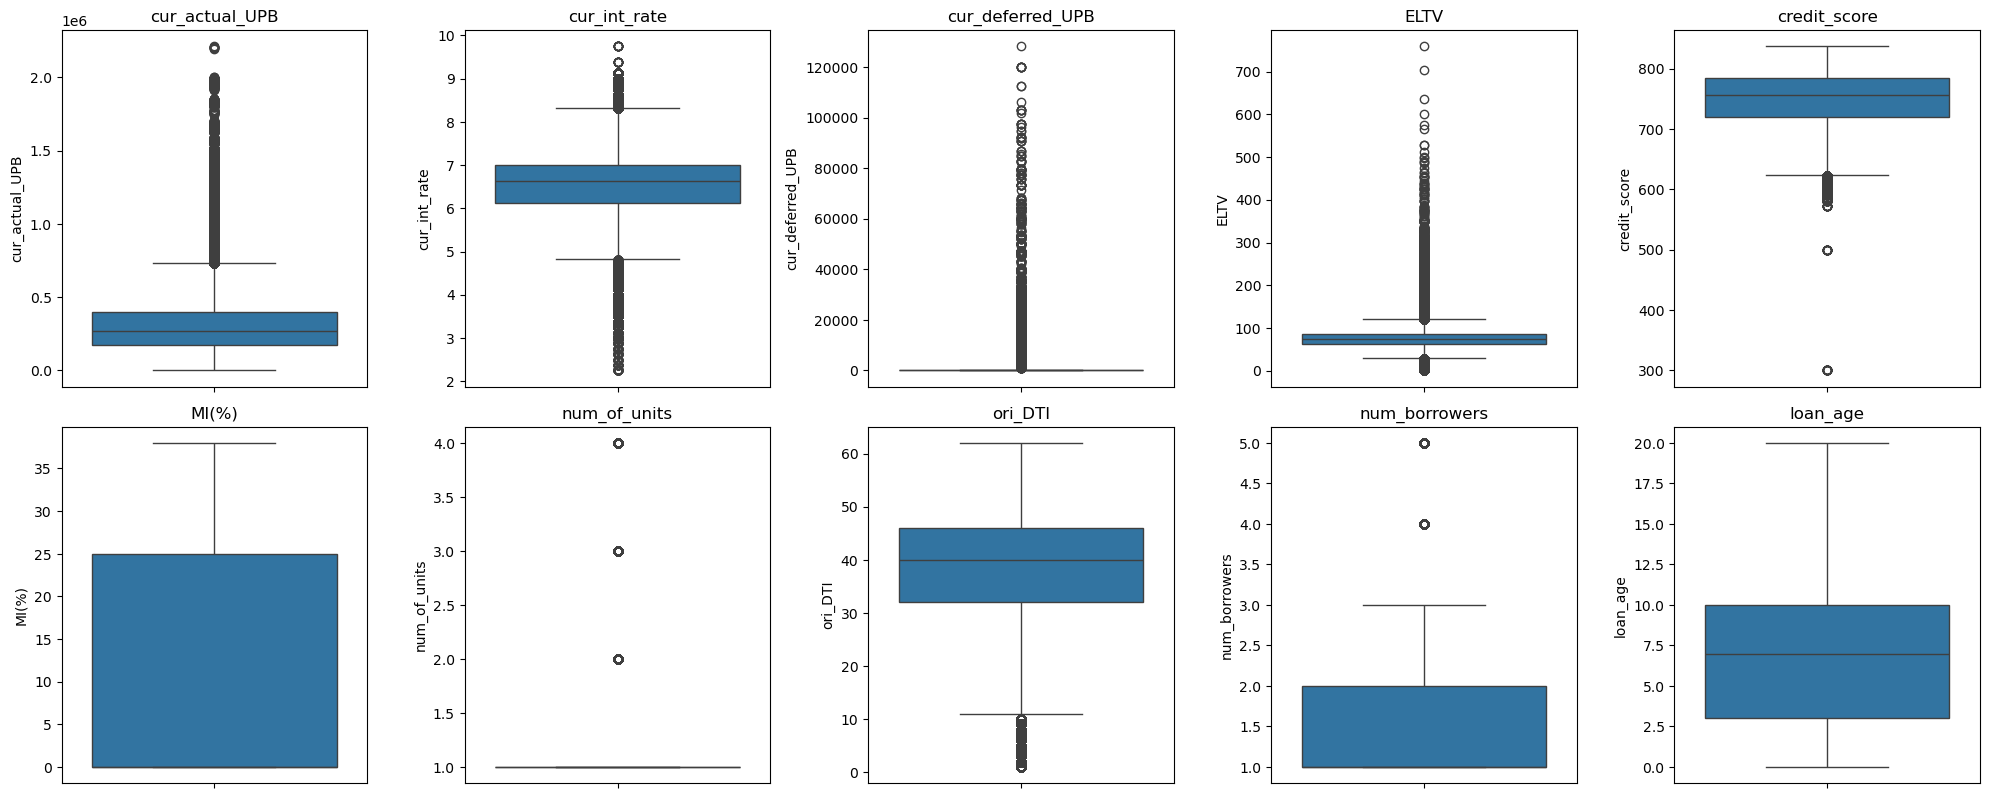

In [19]:
NUM_COLUMNS= df.select_dtypes(include=['number'])
plt.figure(figsize=(20, 12))

# Iterate through all the columns to plot the box plots
for i, col in enumerate(NUM_COLUMNS, 1):
    plt.subplot(3, 5, i)  
    sns.boxplot(data=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

There is no extreme outliers.

In [20]:
# To ensure the numerical variables are within the vaild range
df = df[(df['ori_DTI'] >= 0) & (df['ori_DTI'] <= 65)]
df = df[(df['credit_score'] >= 300) & (df['credit_score'] <= 850)]
df = df[(df['MI(%)'] >= 0) & (df['MI(%)'] <= 55)]
df = df[(df['ELTV'] >= 1) & (df['ELTV'] <= 998)]

---
## 6.0 Encoding
One-hot encoding is used to handle the categorical variables.

In [21]:
CAT_COLUMNS = df.select_dtypes(include=['object']).columns

encoder = OneHotEncoder(drop='first', sparse_output=False)  
encoded_array = encoder.fit_transform(df[CAT_COLUMNS])

feature_names = encoder.get_feature_names_out(CAT_COLUMNS)
df_encoded = pd.DataFrame(encoded_array, columns=feature_names, index=df.index)

df = df.drop(columns=CAT_COLUMNS)
df = pd.concat([df, df_encoded], axis=1)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12979123 entries, 0 to 12983783
Data columns (total 33 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   cur_actual_UPB                 float64
 1   cur_int_rate                   float64
 2   cur_deferred_UPB               float64
 3   ELTV                           float64
 4   credit_score                   float64
 5   MI(%)                          float64
 6   num_of_units                   float64
 7   ori_DTI                        float64
 8   num_borrowers                  float64
 9   loan_age                       float64
 10  target                         bool   
 11  first_time_homebuyer_Y         float64
 12  occupancy_status_P             float64
 13  occupancy_status_S             float64
 14  channel_B                      float64
 15  channel_C                      float64
 16  channel_R                      float64
 17  property_type_CP               float64
 18  prope

In [23]:
RESOURCES_DIR = '../resources'
# To save the one hot encoder
with open("one_hot_encoder.pkl", "wb") as f:
    pickle.dump({
        "encoder": encoder,
        "columns": CAT_COLUMNS  # exact order used in fit
    }, f)

---
## 7.0 Scaling

In [24]:
scaling_metadata = {}
cols_to_save = ['cur_actual_UPB', 'cur_int_rate', 'cur_deferred_UPB', 'ELTV', 'credit_score', 'MI(%)', 'num_of_units', 'ori_DTI','num_borrowers', 'loan_age']

for column in cols_to_save:
    scaling_metadata[column]={
        'min': df[column].min(),
        'max': df[column].max()
    }

# To save the normalisation metadata
with open(os.path.join(RESOURCES_DIR,'scaling_metadata.pkl'), 'wb') as f:
   pickle.dump(scaling_metadata, f)

In [25]:
scaler = MinMaxScaler()
df[['cur_actual_UPB', 'cur_int_rate', 'cur_deferred_UPB', 'ELTV','credit_score', 'MI(%)', 'num_of_units', 'ori_DTI','num_borrowers', 'loan_age']]=scaler.fit_transform(df[['cur_actual_UPB', 'cur_int_rate', 'cur_deferred_UPB', 'ELTV', 'credit_score', 'MI(%)', 'num_of_units', 'ori_DTI','num_borrowers', 'loan_age']])

---
## 8.0 Information about dataset after preprocessed

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12979123 entries, 0 to 12983783
Data columns (total 33 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   cur_actual_UPB                 float64
 1   cur_int_rate                   float64
 2   cur_deferred_UPB               float64
 3   ELTV                           float64
 4   credit_score                   float64
 5   MI(%)                          float64
 6   num_of_units                   float64
 7   ori_DTI                        float64
 8   num_borrowers                  float64
 9   loan_age                       float64
 10  target                         bool   
 11  first_time_homebuyer_Y         float64
 12  occupancy_status_P             float64
 13  occupancy_status_S             float64
 14  channel_B                      float64
 15  channel_C                      float64
 16  channel_R                      float64
 17  property_type_CP               float64
 18  prope

In [27]:
df.head(5)

,cur_actual_UPB,cur_int_rate,cur_deferred_UPB,ELTV,credit_score,MI(%),num_of_units,ori_DTI,num_borrowers,loan_age,...,property_valuation_method_2.0,property_valuation_method_3.0,property_valuation_method_4.0,quarter_2,quarter_3,quarter_4,region_Northeast,region_Other,region_South,region_West
0,0.047016,0.566667,0.0,0.093272,0.919926,0.0,0.0,0.606557,0.0,0.00,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.047016,0.566667,0.0,0.101583,0.919926,0.0,0.0,0.606557,0.0,0.05,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.046564,0.566667,0.0,0.100264,0.919926,0.0,0.0,0.606557,0.0,0.10,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.045208,0.566667,0.0,0.096306,0.919926,0.0,0.0,0.606557,0.0,0.15,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.044756,0.566667,0.0,0.094987,0.919926,0.0,0.0,0.606557,0.0,0.20,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


---
## 9.0 Data Splitting
The dataset is split into 60% train set, 20% test set and 20% of validation set. 

In [28]:
RANDOM_STATE = 42

df_train: pd.DataFrame
df_test: pd.DataFrame

# 60% Train, 40% Test+Validation
df_train, df_temp = train_test_split(df, test_size=0.40, random_state=RANDOM_STATE, shuffle=True) #, stratify=df["target"]

# Split df_temp into 20% Test, 20% Validation
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=RANDOM_STATE, shuffle=True) #, stratify=df_temp["target"]

print("Train set size: ", df_train.shape)
print("Test set size: ", df_test.shape)
print("Validation set size: ", df_val.shape)

Train set size:  (7787473, 33)
Test set size:  (2595825, 33)
Validation set size:  (2595825, 33)


In [29]:
# Save the datasets
df_train.to_parquet(os.path.join(DATASET_DIR, 'Train_Set'), index=False)
df_test.to_parquet(os.path.join(DATASET_DIR, 'Test_Set'), index=False)
df_val.to_parquet(os.path.join(DATASET_DIR, 'Validation_Set'), index=False)

---
## 10.0 Features Selection Summary
#### Features that are selected: 
|**No.** | **Feature**           | **Type**        |
 ---------|-----------------------|-----------------|
| 1| `cur_actual_UPB`         |  Numerical |
| 2| `cur_int_rate`       |  Numerical |
| 3| `cur_deferred_UPB`         | Numerical |
| 4| `ELTV`       |  Numerical |
| 5| `credit_score`       | Numerical |
| 6| `MI(%)`       |  Numerical |
| 7| `num_of_units`       | Numerical |
| 8| `ori_DTI`       | Numerical |
| 9| `num_borrowers`         | Numerical |
| 10| `loan_age`       |  Numerical |
| 11| `first_time_homebuyer`       |  Categorical |
| 12| `occupancy_status`         | Categorical |
| 13| `channel`       |  Categorical |
| 14| `property_type`         |  Categorical |
| 15| `loan_purpose`         | Categorical |
| 16| `property_valuation_method`         | Categorical |
| 17| `quarter`         | Categorical |
| 18| `region`         | Categorical |